In [8]:
import pandas as pd
from pathlib import Path

ROOT = Path("..").resolve()
DATA_RAW = ROOT / "data_raw"
DATA_PROCESSED = ROOT / "data_processed"

perf = pd.read_csv(DATA_RAW / "store_performance_2018to2022.csv")
perf["invoice_date"] = pd.to_datetime(perf["invoice_date"]).dt.normalize()
perf["store_id"] = perf["store_id"].astype(int)

# Ensure unique perf keys (safe)
if perf.duplicated(["store_id","invoice_date"]).any():
    perf = (perf.groupby(["store_id","invoice_date"], as_index=False)
              .agg({"invoice_count":"sum","oc_count":"sum","fleet_oc_count":"sum"}))

weather_all = pd.read_parquet(DATA_PROCESSED / "weather_allstores.parquet")
weather_all["invoice_date"] = pd.to_datetime(weather_all["invoice_date"]).dt.normalize()
weather_all["store_id"] = weather_all["store_id"].astype(int)

m = perf.merge(weather_all, on=["store_id","invoice_date"], how="inner").drop_duplicates(["store_id","invoice_date"])

print("Merged rows:", len(m))
print("Stores:", m["store_id"].nunique())
print("Dup keys:", m.duplicated(["store_id","invoice_date"]).sum())
m.head()

Merged rows: 756701
Stores: 434
Dup keys: 0


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tavg,tmin,tmax,prcp,wspd,snow
0,2020-03-02,86856,72,59,6,11.6,10.0,15.0,4.3,9.8,0.0
1,2020-03-12,601811,91,82,5,11.2,2.8,18.3,11.9,6.5,0.0
2,2020-03-23,230710,32,26,4,5.2,3.3,7.8,0.0,5.8,NaN
3,2020-03-07,611647,45,39,0,4.1,1.0,8.0,NaN,7.5,NaN
4,2020-03-06,614362,87,80,7,13.6,7.8,18.9,0.0,10.7,NaN


In [9]:
import numpy as np

m = m.sort_values(["store_id","invoice_date"]).copy()

# Calendar + trend
m["dow"] = m["invoice_date"].dt.dayofweek
m["month"] = m["invoice_date"].dt.month
m["day_of_year"] = m["invoice_date"].dt.dayofyear
m["year"] = m["invoice_date"].dt.year
m["is_weekend"] = (m["dow"] >= 5).astype(int)
m["time_index"] = m.groupby("store_id").cumcount()

# Weather intensity + flags
m["rain_mm"] = m["prcp"].fillna(0.0)
m["snow_cm"] = m["snow"].fillna(0.0)
m["temp_range"] = m["tmax"] - m["tmin"]

m["is_rain"] = (m["rain_mm"] > 0).astype(int)
m["is_snow"] = (m["snow_cm"] > 0).astype(int)
m["is_freezing"] = (m["tmin"].fillna(99) <= 0).astype(int)

m["heavy_rain"] = (m["rain_mm"] >= 10).astype(int)
m["heavy_snow"] = (m["snow_cm"] >= 5).astype(int)
m["severe_weather"] = ((m["tmin"] <= -5) | (m["snow_cm"] >= 5) | (m["rain_mm"] >= 15)).astype(int)

# Demand memory (NO leakage)
g = m.groupby("store_id")["invoice_count"]
m["inv_lag_1"] = g.shift(1)
m["inv_lag_7"] = g.shift(7)
m["inv_lag_14"] = g.shift(14)

m["inv_roll7_mean"]  = g.shift(1).rolling(7,  min_periods=3).mean().reset_index(level=0, drop=True)
m["inv_roll14_mean"] = g.shift(1).rolling(14, min_periods=5).mean().reset_index(level=0, drop=True)
m["inv_roll28_mean"] = g.shift(1).rolling(28, min_periods=10).mean().reset_index(level=0, drop=True)

# Weather carryover (NO leakage)
for col in ["prcp","snow","tavg"]:
    s = m.groupby("store_id")[col]
    m[f"{col}_lag_1"] = s.shift(1)
    m[f"{col}_roll7_mean"] = s.shift(1).rolling(7, min_periods=3).mean().reset_index(level=0, drop=True)

print("Features added. Rows:", len(m), "Stores:", m["store_id"].nunique())

Features added. Rows: 756701 Stores: 434


In [10]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

TARGET = "invoice_count"

# ---- Split: train 2018-2021, validate 2022 ----
train_df = m[m["invoice_date"].dt.year.isin([2018, 2019, 2020, 2021])].copy()
valid_df = m[m["invoice_date"].dt.year.isin([2022])].copy()

print("Train rows:", len(train_df), "| Valid rows:", len(valid_df))
print("Leakage check:", train_df["invoice_date"].max() < valid_df["invoice_date"].min())

# ---- Feature list (same as before) ----
base = ["store_id","dow","month","day_of_year","year","is_weekend","time_index"]

weather_now = [
    "tmin","tmax","tavg","prcp","wspd","snow","temp_range",
    "rain_mm","snow_cm","is_rain","is_snow","is_freezing",
    "heavy_rain","heavy_snow","severe_weather"
]

demand = [
    "inv_lag_1","inv_lag_7","inv_lag_14",
    "inv_roll7_mean","inv_roll14_mean","inv_roll28_mean"
]

weather_roll = [
    "prcp_lag_1","prcp_roll7_mean",
    "snow_lag_1","snow_roll7_mean",
    "tavg_lag_1","tavg_roll7_mean"
]

feature_cols = [c for c in (base + weather_now + demand + weather_roll) if c in train_df.columns]
print("Features used:", len(feature_cols))

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].astype(float)

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df[TARGET].astype(float)

categorical = ["store_id"]
numeric = [c for c in feature_cols if c not in categorical]

# ---- Preprocess: force DENSE output for HGB ----
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
    ],
    sparse_threshold=0.0
)

hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_depth=6,
    max_iter=800
)

pipe_hgb = Pipeline([("prep", preprocess), ("model", hgb)])
pipe_hgb.fit(X_train, y_train)

pred = np.clip(pipe_hgb.predict(X_valid), 0, None)

def safe_mape(y_true, y_pred, min_true=1.0):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true >= min_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(y_valid, pred)
smape = safe_mape(y_valid, pred)

print("\nHGB (ALL stores) Train 2018–2021, Validate 2022")
print("MAE :", round(mae, 2))
print("safeMAPE:", round(smape, 2), "%")
print("Zero invoice days in valid:", int((y_valid == 0).sum()))

Train rows: 603834 | Valid rows: 152867
Leakage check: True
Features used: 34

HGB (ALL stores) Train 2018–2021, Validate 2022
MAE : 7.36
safeMAPE: 18.56 %
Zero invoice days in valid: 13


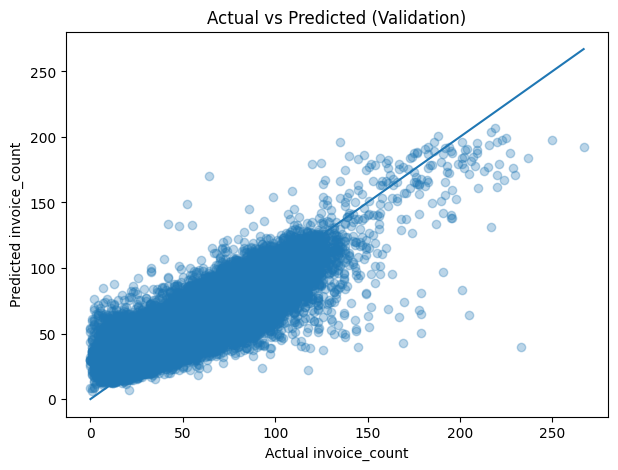

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(y_valid, pred, alpha=0.3)

# y = x reference line
min_v = float(np.min([np.min(y_valid), np.min(pred)]))
max_v = float(np.max([np.max(y_valid), np.max(pred)]))
plt.plot([min_v, max_v], [min_v, max_v])

plt.xlabel("Actual invoice_count")
plt.ylabel("Predicted invoice_count")
plt.title("Actual vs Predicted (Validation)")
plt.show()

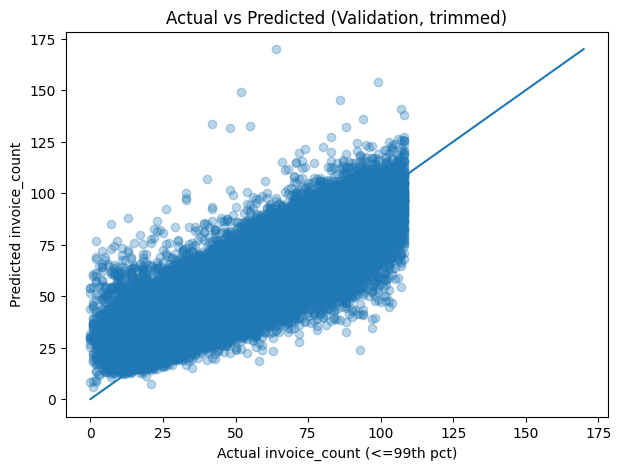

In [12]:
import numpy as np
import matplotlib.pyplot as plt

p99 = np.percentile(y_valid, 99)
mask = y_valid <= p99

plt.figure(figsize=(7,5))
plt.scatter(np.array(y_valid)[mask], np.array(pred)[mask], alpha=0.3)

min_v = float(np.min([np.min(np.array(y_valid)[mask]), np.min(np.array(pred)[mask])]))
max_v = float(np.max([np.max(np.array(y_valid)[mask]), np.max(np.array(pred)[mask])]))
plt.plot([min_v, max_v], [min_v, max_v])

plt.xlabel("Actual invoice_count (<=99th pct)")
plt.ylabel("Predicted invoice_count")
plt.title("Actual vs Predicted (Validation, trimmed)")
plt.show()

In [13]:
import pandas as pd
err_df = pd.DataFrame({
    "store_id": valid_df["store_id"].values,
    "invoice_date": valid_df["invoice_date"].values,
    "actual": y_valid,
    "pred": pred,
})
err_df["abs_error"] = (err_df["actual"] - err_df["pred"]).abs()
err_df.sort_values("abs_error", ascending=False).head(10000)

,store_id,invoice_date,actual,pred,abs_error
705558,102098,2022-05-20,233.0,39.761067,193.238933
425967,274137,2022-08-11,205.0,63.783283,141.216717
715540,232116,2022-05-20,179.0,50.200371,128.799629
715867,232116,2022-05-10,169.0,42.955930,126.044070
745962,102302,2022-03-18,201.0,82.882462,118.117538
...,...,...,...,...,...
755468,88321,2022-03-07,48.0,65.781369,17.781369
632370,227790,2022-06-07,40.0,57.781041,17.781041
573133,594271,2022-12-24,37.0,54.780413,17.780413
453171,103480,2022-10-13,29.0,46.780081,17.780081


In [14]:
import json
import joblib
import pandas as pd
from pathlib import Path

# Paths (notebooks/ -> project root)
ROOT = Path("..").resolve()
DATA_PROCESSED = ROOT / "data_processed"
REPORTS = ROOT / "reports"
DATA_PROCESSED.mkdir(exist_ok=True)
REPORTS.mkdir(exist_ok=True)

# Filenames (edit if you want)
MODEL_FILE = DATA_PROCESSED / "model_hgb_allstores.joblib"
FEATURES_FILE = DATA_PROCESSED / "feature_cols_hgb_allstores.json"
PRED_FILE = DATA_PROCESSED / "predictions_hgb_allstores.csv"
METRICS_FILE = REPORTS / "metrics_hgb_allstores.json"

# 1) Save model pipeline
joblib.dump(pipe_hgb, MODEL_FILE)

# 2) Save feature columns used
with open(FEATURES_FILE, "w") as f:
    json.dump(feature_cols, f, indent=2)

# 3) Save predictions (validation set)
pred_df = pd.DataFrame({
    "store_id": valid_df["store_id"].values,
    "invoice_date": valid_df["invoice_date"].values,
    "actual": valid_df["invoice_count"].astype(float).values,
    "pred": pred
})
pred_df["abs_error"] = (pred_df["actual"] - pred_df["pred"]).abs()
pred_df.to_csv(PRED_FILE, index=False)

# 4) Save metrics
metrics = {
    "model": "HistGradientBoostingRegressor",
    "target": "invoice_count",
    "mae": float(mae),
    "safe_mape": float(smape),
    "n_train": int(len(train_df)),
    "n_valid": int(len(valid_df)),
    "n_stores": int(m["store_id"].nunique()),
    "features_count": int(len(feature_cols))
}
with open(METRICS_FILE, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model:", MODEL_FILE)
print("Saved features:", FEATURES_FILE)
print("Saved predictions:", PRED_FILE)
print("Saved metrics:", METRICS_FILE)

# Quick check
loaded = joblib.load(MODEL_FILE)
print("Load test OK:", type(loaded))
pred_df.head()

Saved model: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/model_hgb_allstores.joblib
Saved features: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/feature_cols_hgb_allstores.json
Saved predictions: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/predictions_hgb_allstores.csv
Saved metrics: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/reports/metrics_hgb_allstores.json
Load test OK: <class 'sklearn.pipeline.Pipeline'>


,store_id,invoice_date,actual,pred,abs_error
0,79609,2022-01-02,37.0,41.495976,4.495976
1,79609,2022-01-03,60.0,60.177973,0.177973
2,79609,2022-01-04,62.0,58.795303,3.204697
3,79609,2022-01-05,52.0,65.497525,13.497525
4,79609,2022-01-06,16.0,52.556423,36.556423


In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path("..").resolve()  # notebook is inside /notebooks
DATA_RAW = ROOT / "data_raw"
DATA_PROCESSED = ROOT / "data_processed"

# Load perf + cached all-stores weather
perf = pd.read_csv(DATA_RAW / "store_performance_2018to2022.csv")
perf["invoice_date"] = pd.to_datetime(perf["invoice_date"]).dt.normalize()
perf["store_id"] = perf["store_id"].astype(int)

# Ensure unique perf keys
if perf.duplicated(["store_id","invoice_date"]).any():
    perf = (perf.groupby(["store_id","invoice_date"], as_index=False)
              .agg({"invoice_count":"sum","oc_count":"sum","fleet_oc_count":"sum"}))

weather_all = pd.read_parquet(DATA_PROCESSED / "weather_allstores.parquet")
weather_all["invoice_date"] = pd.to_datetime(weather_all["invoice_date"]).dt.normalize()
weather_all["store_id"] = weather_all["store_id"].astype(int)
weather_all = weather_all.drop_duplicates(["store_id","invoice_date"])

# Merge
m = perf.merge(weather_all, on=["store_id","invoice_date"], how="inner").drop_duplicates(["store_id","invoice_date"])
m = m.sort_values(["store_id","invoice_date"]).reset_index(drop=True)

# ---- Feature engineering (same as your model B) ----
m["dow"] = m["invoice_date"].dt.dayofweek
m["month"] = m["invoice_date"].dt.month
m["day_of_year"] = m["invoice_date"].dt.dayofyear
m["year"] = m["invoice_date"].dt.year
m["is_weekend"] = (m["dow"] >= 5).astype(int)
m["time_index"] = m.groupby("store_id").cumcount()

for c in ["tmin","tmax","tavg","prcp","wspd","snow"]:
    if c in m.columns:
        m[c] = pd.to_numeric(m[c], errors="coerce")

m["rain_mm"] = m["prcp"].fillna(0.0)
m["snow_cm"] = m["snow"].fillna(0.0)
m["temp_range"] = m["tmax"] - m["tmin"]

m["is_rain"] = (m["rain_mm"] > 0).astype(int)
m["is_snow"] = (m["snow_cm"] > 0).astype(int)
m["is_freezing"] = (m["tmin"].fillna(99) <= 0).astype(int)

m["heavy_rain"] = (m["rain_mm"] >= 10).astype(int)
m["heavy_snow"] = (m["snow_cm"] >= 5).astype(int)
m["severe_weather"] = ((m["tmin"] <= -5) | (m["snow_cm"] >= 5) | (m["rain_mm"] >= 15)).astype(int)

g = m.groupby("store_id")["invoice_count"]
m["inv_lag_1"] = g.shift(1)
m["inv_lag_7"] = g.shift(7)
m["inv_lag_14"] = g.shift(14)

m["inv_roll7_mean"]  = g.shift(1).rolling(7,  min_periods=3).mean().reset_index(level=0, drop=True)
m["inv_roll14_mean"] = g.shift(1).rolling(14, min_periods=5).mean().reset_index(level=0, drop=True)
m["inv_roll28_mean"] = g.shift(1).rolling(28, min_periods=10).mean().reset_index(level=0, drop=True)

for col in ["prcp","snow","tavg"]:
    s = m.groupby("store_id")[col]
    m[f"{col}_lag_1"] = s.shift(1)
    m[f"{col}_roll7_mean"] = s.shift(1).rolling(7, min_periods=3).mean().reset_index(level=0, drop=True)

# Keep only 2022 rows for fast demo lookup
demo_2022 = m[m["invoice_date"].dt.year == 2022].copy()

out_path = DATA_PROCESSED / "demo_features_2022.parquet"
demo_2022.to_parquet(out_path, index=False)

print("Saved demo table:", out_path)
print("Rows:", len(demo_2022), "| Stores:", demo_2022["store_id"].nunique())
demo_2022[["store_id","invoice_date","invoice_count"]].head()

Saved demo table: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/demo_features_2022.parquet
Rows: 152867 | Stores: 434


,store_id,invoice_date,invoice_count
1432,79609,2022-01-02,37
1433,79609,2022-01-03,60
1434,79609,2022-01-04,62
1435,79609,2022-01-05,52
1436,79609,2022-01-06,16
